### Peforming PCA with an Undercomplete Linear Autoencoder

In [2]:
import tensorflow as tf

In [3]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])

autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

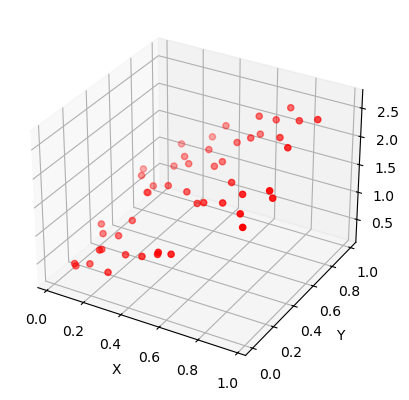

In [4]:
# generating 3d dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
num_points = 50

# Generate random values for X and Y
X = np.random.rand(num_points)
Y = np.random.rand(num_points)

# Create a linear relationship with some noise for Z
slope = 2
intercept = 1
noise = np.random.normal(0, 0.1, num_points)
Z = slope * X + intercept * Y + noise

# Plot the 3D dataset
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [5]:
# organize the data into a 3D array
X_train = np.array([[[x, y, z] for x, y, z in zip(X, Y, Z)]])
X_train.ndim

3

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=5)
codings = encoder.predict(X_train)

Epoch 1/5


In [ ]:
codings